#0. Imports

In [ ]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive/')
data_path = '/content/drive/Shareddrives/IR'
output_path = '/content/drive/Shareddrives/IR/outputs/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install config

In [ ]:
from sklearn.manifold import TSNE
import pickle

In [ ]:
from google.colab import files
uploaded = files.upload()
for file in uploaded:
  print("file name : {} , length: {}".format(file,len(file)))

Saving myfunctions.py to myfunctions.py
file name : myfunctions.py , length: 14


In [ ]:
from myfunctions import *

In [ ]:
 OUTPUT_FILENAME = "/data/tweets100_hydrated.json"

 with open(data_path+OUTPUT_FILENAME, 'r') as f:
    lines = f.readlines()
    data = [json.loads(str_) for str_ in lines]

In [ ]:
df_tweets = pd.DataFrame.from_records(data)
df_tweets["retweeted_status"]=df_tweets["retweeted_status"].apply(lambda x: 0 if str(x)=="nan" else x)

df_original = df_tweets[df_tweets["retweeted_status"]==0]
#0: tweets are not RT
#1: tweets are RT
df_original.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,possibly_sensitive,extended_entities,withheld_in_countries
1,Thu Dec 17 13:47:46 +0000 2020,1339567967223250947,1339567967223250947,Oh yr eh ohi nhi aa jine corona kr k parliamen...,False,"[0, 157]","{'hashtags': [{'text': 'FarmersProtest', 'indi...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 863024748590059521, 'id_str': '86302474...",None,None,None,None,0,True,1,7,False,False,en,1.339402e+18,1339402143866912770,"{'url': 'https://t.co/S8foPwBiKY', 'expanded':...",{'created_at': 'Thu Dec 17 02:48:50 +0000 2020...,False,NaN,NaN
4,Thu Dec 17 13:47:46 +0000 2020,1339567967613366272,1339567967613366272,@sambosnumerouno @MENnewsdesk @ccoxmenmedia Ye...,False,"[44, 322]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",1.339567e+18,1339566783964045312,9.286508e+17,928650799349161984,sambosnumerouno,"{'id': 2831341487, 'id_str': '2831341487', 'na...",None,None,None,None,0,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Thu Dec 17 13:47:46 +0000 2020,1339567967680475136,1339567967680475136,How about not acknowledging Covid\nThe dangers...,False,"[0, 196]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,None,NaN,None,None,"{'id': 802581205262696448, 'id_str': '80258120...",None,None,None,None,0,True,0,0,False,False,en,1.339376e+18,1339375759677411328,"{'url': 'https://t.co/ukUd8G4XQP', 'expanded':...",{'created_at': 'Thu Dec 17 01:04:00 +0000 2020...,False,NaN,NaN
8,Thu Dec 17 13:47:46 +0000 2020,1339567967718305794,1339567967718305794,fuck we really boutta be 5-9 😔 https://t.co/h8...,False,"[0, 30]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1037829476267249664, 'id_str': '1037829...",None,None,None,None,0,True,0,1,False,False,en,1.339568e+18,1339567549768491012,"{'url': 'https://t.co/h8gTqdoBfm', 'expanded':...",{'created_at': 'Thu Dec 17 13:46:06 +0000 2020...,False,NaN,NaN
11,Thu Dec 17 13:47:46 +0000 2020,1339567968234201093,1339567968234201093,oh no 😂 https://t.co/op7jImeDRi,False,"[0, 7]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1313181832700194818, 'id_str': '1313181...",None,None,None,None,0,True,0,0,False,False,en,1.339568e+18,1339567549768491012,"{'url': 'https://t.co/op7jImeDRi', 'expanded':...",{'created_at': 'Thu Dec 17 13:46:06 +0000 2020...,False,NaN,NaN


#RQ1. B
Return a top-20 list of documents for each of the 10 queries, using tf-idf + cosine similarity methods




TF-IDF

In [ ]:
start_time = time.time()
numDocuments = len(df_original)
index, tf, df, idf = create_index_tfidf(df_original, numDocuments)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 157.91 seconds


In [ ]:
def search_tf_idf(query, index,df):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''

    query=preprocess_tweet(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs |= set(termDocs)
        except:
            #term is not in index
            pass


    ranked_docs = rankDocuments(query, docs, index, idf, tf) 

    docs=list(ranked_docs)
    output = []


    for i in docs:
      hashtag = []
      if df.loc[i]["entities"]["hashtags"]:
        for k in range(len(df.loc[i]["entities"]["hashtags"])):
          hashtag.append(df.loc[i]["entities"]["hashtags"][k]["text"])
      else:
        hashtag.append("No Hashtags")

      text = regex.sub('@[^\s]+', '', df.loc[i]["full_text"])
      text = regex.sub(r'http\S+', '', text)

    
      output.append([query,text, df.loc[i]["user"]["screen_name"], df.loc[i]["created_at"], hashtag, df.loc[i]["favorite_count"], df.loc[i]["retweet_count"],regex.findall('http\S+', df.loc[i]["full_text"])])

    
    
    return output

In [ ]:
queries = ["Obama", "Pfizer", "Trump", "Moderna", "Macron", "Germany", "Spain", "restaurant", "economy", "school"]
ranked_docsRQ1b = []

for query in queries:
  new_ranking = search_tf_idf(query, index,df_original)
  for i in range(0,20):
    ranked_docsRQ1b.append(new_ranking[i])




In [ ]:
df_RQ1b = pd.DataFrame(ranked_docsRQ1b, columns = ["Query","Tweet", "Username", "Date", "Hashtags", "Likes", "Retweets", "URL"])

df_RQ1b

,Query,Tweet,Username,Date,Hashtags,Likes,Retweets,URL
0,[obama],Now do Reagan through Obama.,J_Dubya80,Thu Dec 17 14:01:56 +0000 2020,[No Hashtags],0,0,[https://t.co/QEd7LnMW3E]
1,[obama],Why would Trump trust Obama’s pandemic t...,FightandDebate,Thu Dec 17 13:53:28 +0000 2020,[No Hashtags],0,0,[]
2,[obama],But Obama wore a tan suit?,ssurovell,Thu Dec 17 13:53:57 +0000 2020,[No Hashtags],52,7,[https://t.co/wr6XbZvQXt]
3,[obama],Corona virus vaccine research was started an...,EntropyJimJohn,Thu Dec 17 14:14:07 +0000 2020,[No Hashtags],0,0,[]
4,[obama],GOP congressman who once shouted ‘you lie’ dur...,thomaskaine5,Thu Dec 17 14:12:41 +0000 2020,[No Hashtags],85,27,[https://t.co/2HVGDpakUR]
...,...,...,...,...,...,...,...,...
195,[school],School boards ask Gov. Greg Abbott to prioriti...,KodeeRolden,Thu Dec 17 14:15:32 +0000 2020,[No Hashtags],0,0,[https://t.co/1wKwqMTqO2]
196,[school],"Our schools were also fortunate, but it’s a n...",AmandavMulligen,Thu Dec 17 13:48:47 +0000 2020,[No Hashtags],1,0,[]
197,[school],Indian Creek Local School District officials h...,HeraldStar,Thu Dec 17 14:04:37 +0000 2020,[No Hashtags],3,1,[https://t.co/xGf2MDOXt0]
198,[school],...rn during a pandemic and we r doing online...,RealBrownyPlays,Thu Dec 17 13:54:07 +0000 2020,[No Hashtags],0,0,[]


In [ ]:
df_RQ1b.to_csv(output_path+"df_RQ1b.csv", sep =";")

#RQ1. C
Return a top-20 list of documents for each of the 10 queries, using word2vec + cosine similarity methods

In [ ]:
#generation of an instance of class TwitterArchiveCorpus to have all its return functions
tweets = TwitterArchiveCorpus(df_original)

In [ ]:
#split paragraphs into sentences
sentences = list(get_sentences(df_original["full_text"]))
#split each sentence into a list od words
words = [s.split() for s in sentences ]

Progress: 10000
Progress: 20000
Progress: 30000
Progress: 40000


In [ ]:
#word2vec model
w2v = Word2Vec(sentences = words, size=100, window=10, min_count=10, negative=15, sg = 0)

In [ ]:
#generation of vectors per tweet
def generate_vector_sums():
    for doc in tweets.iter_texts(): 
        yield gensim.matutils.unitvec(  
            sum(
                (w2v[word] for word in doc if word in w2v),
                numpy.zeros(w2v.vector_size)
            )
        )


In [ ]:
#find most 50 similar tweets
w2v_index = gensim.similarities.Similarity('/tmp/w2v_tweets',
                                           generate_vector_sums(),
                                           num_features=w2v.vector_size,
                                           num_best=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
def search_w2v(query, top):
    query_tokens = preprocess_tweet(query)
    query_vec = gensim.matutils.unitvec(sum((w2v[word] for word in query_tokens if word in w2v), numpy.zeros(w2v.vector_size)))

    output = []
    for doc, percent in w2v_index[query_vec][:top]:

      output.append([query,tweets.get_original(doc), tweets.get_original_username(doc), tweets.get_original_date(doc), tweets.get_original_hashtags(doc), tweets.get_original_likes(doc), 
                    tweets.get_original_retweets(doc), tweets.get_original_url(doc)])
    return output

In [ ]:
queries = ["Obama", "Pfizer", "Trump", "Moderna", "Macron", "Germany", "Spain", "restaurant", "economy", "school"]
ranked_docsRQ1c = []

for query in queries:
  new_ranking = search_w2v(query, 20)
  for i in range(0,20):
    ranked_docsRQ1c.append(new_ranking[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_RQ1c = pd.DataFrame(ranked_docsRQ1c, columns = ["Query","Tweet", "Username", "Date", "Hashtags", "Likes", "Retweets", "URL"])

df_RQ1c

,Query,Tweet,Username,Date,Hashtags,Likes,Retweets,URL
0,Obama,Now do Reagan through Obama. https://t.co/QEd7...,J_Dubya80,Thu Dec 17 14:01:56 +0000 2020,[No Hashtags],0,0,[https://t.co/QEd7LnMW3E]
1,Obama,"In fairness, the President is a dumb fucker. h...",JoHoSnow,Thu Dec 17 13:50:01 +0000 2020,[No Hashtags],0,0,[https://t.co/8kePv6JmrQ]
2,Obama,of course President Xi has absolutely no idea....,spencerreiss,Thu Dec 17 13:52:16 +0000 2020,[No Hashtags],0,0,[https://t.co/wT12HGwlO1]
3,Obama,@GovChristie @gtconway3d Too late Christie. Wa...,MrsWormdog,Thu Dec 17 14:13:02 +0000 2020,[No Hashtags],0,0,[]
4,Obama,This kind of callousness started at the top wi...,JanEngleLewis1,Thu Dec 17 14:08:45 +0000 2020,[No Hashtags],0,0,[https://t.co/B0RhsMRUL1]
...,...,...,...,...,...,...,...,...
195,school,Picking up my kids from school. https://t.co/A...,marie_croke,Thu Dec 17 13:51:08 +0000 2020,[No Hashtags],0,0,[https://t.co/ACRKpwJVlL]
196,school,So stagger return but don’t you dare close sch...,nash_gelnash,Thu Dec 17 14:03:54 +0000 2020,[No Hashtags],0,0,"[https://t.co/v3sH2EHWQM, https://t.co/NbDcBcr..."
197,school,This is the worst option. Teaching some studen...,physics_jamie,Thu Dec 17 13:56:35 +0000 2020,"[schools, education, coronavirus]",0,0,[https://t.co/spI1Xw9YJJ]
198,school,Germany and the Netherlands shut down the scho...,Heaudrais,Thu Dec 17 13:59:59 +0000 2020,[No Hashtags],1,1,[https://t.co/8o8xiOUwdq]


In [ ]:
df_RQ1c.to_csv(output_path+"df_RQ1c.csv", sep =";")

#TSNE

In [ ]:
def vectorize_tweet(tweet):  
    """
    Convert a tweet to vector space using a pre-trained word2vec model
    """
    tweet_vector = np.zeros(100)
    preprocessed_tweet= preprocess_tweet(tweet)

    for word in preprocessed_tweet:
      if word in w2v.wv.vocab:
        tweet_vector = tweet_vector + w2v[word]
    return tweet_vector

In [ ]:
#vectorizing the tweets
vectorize=[]
dictionary=[]
dictio={}
for i in df_original['full_text'].index:
  vectorize.append(vectorize_tweet(df_original['full_text'][i]))
  dictionary.append(df_original['full_text'][i])
  tuples=(vectorize_tweet(df_original['full_text'][i]),df_original['full_text'][i])
  
  dictio[i]=tuples



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#we pass from vectors to points
n,m=np.array(vectorize).shape
tsne_model_en_2d = TSNE(perplexity=20, n_components=2, init='pca', n_iter=3500, random_state=32,n_jobs=-1)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(np.array(vectorize)))

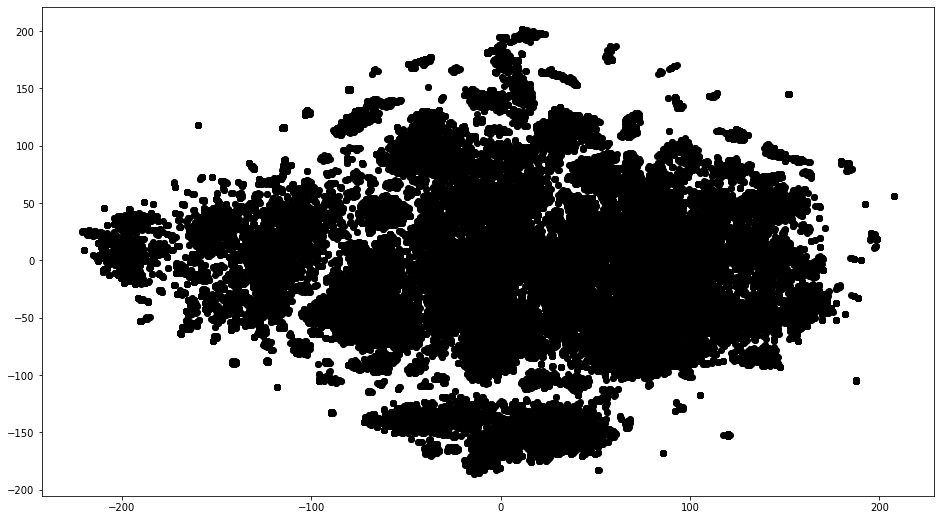

In [ ]:
#TSNE PLOT
total_points=[]
plt.figure(figsize=(16, 9))
for  embeddings in embeddings_en_2d:

  points=[]

  x = embeddings[0]
  y = embeddings[1]
  points.append(x)
  points.append(y)
  total_points.append(points)
  plt.scatter(x, y, c='black')
plt.show()

## Clustering

In [ ]:
df_=pd.DataFrame(columns=('x','y'))
for i in range(len (total_points) ):
  df_.loc[i]=[total_points[i][0], total_points[i][1]]

In [ ]:
#we use the elbow method in order to see the appropiate number of clusters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_)
    distortions.append(kmeanModel.inertia_)

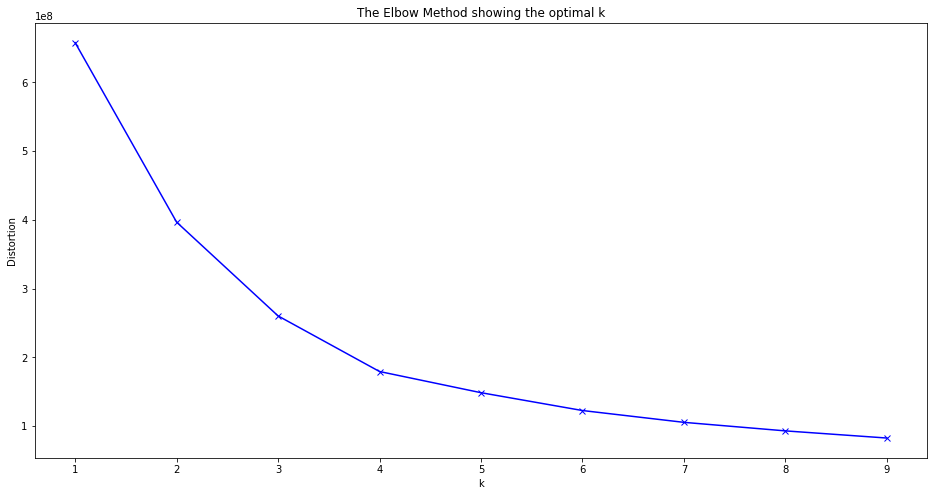

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

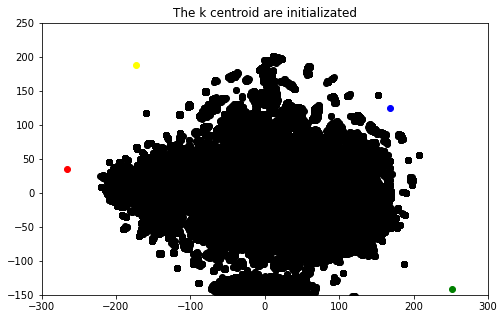

In [ ]:
# number of centroids k = 4 (looking at the first line with less slope)
k = 4
#initialazing the centroids to random values in the data space
centroids = {
    i+1: [np.random.randint(-300, 300), np.random.randint(-150, 250)]
    for i in range(k)
}
     
fig = plt.figure(figsize=(8, 5))


plt.scatter(np.array(df_['x']), np.array(df_['y']), color='black')
  
colmap = {1: 'r', 2: 'g', 3: 'b',4: 'yellow', 5: 'pink', 6: 'purple'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.title(u'The k centroid are initializated')
plt.xlim(-300, 300)
plt.ylim(-150, 250)
plt.show()

(-150.0, 250.0)

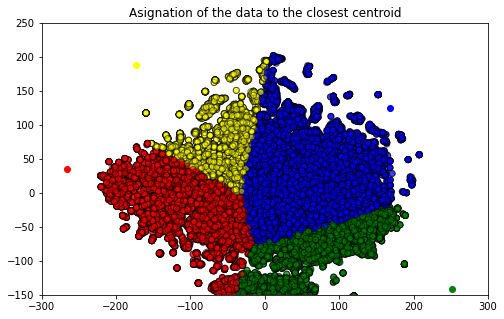

In [ ]:
## Asignation of the data to the closest centroid
 
def asignacion(df, centroids):
    for i in centroids.keys():
        # sqrt((x1 - c1)^2 - (x2 - c2)^2)
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroids[i][0]) ** 2
                + (df['y'] - centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]

    
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df
  
df = asignacion(df_,centroids)
fig = plt.figure(figsize=(8, 5))
plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.title(u'Asignation of the data to the closest centroid')
plt.xlim(-300, 300)
plt.ylim(-150, 250)

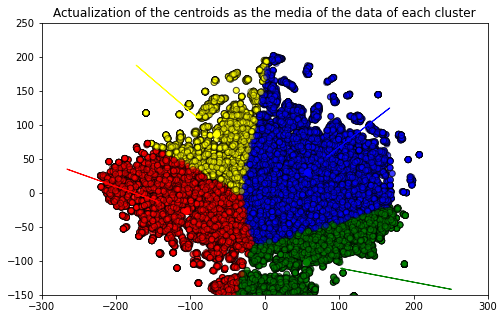

In [ ]:
## Actualization of the centroids
 
import copy
old_centroids = copy.deepcopy(centroids)
 
def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['x'])
        centroids[i][1] = np.mean(df[df['closest'] == i]['y'])
    return k
 
centroids = update(centroids)
     
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()
plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.title(u'Actualization of the centroids as the media of the data of each cluster')
plt.xlim(-300, 300)
plt.ylim(-150, 250)
for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    ax.arrow(old_x, old_y, dx, dy, head_width=2, head_length=3, fc=colmap[i], ec=colmap[i])
plt.show()

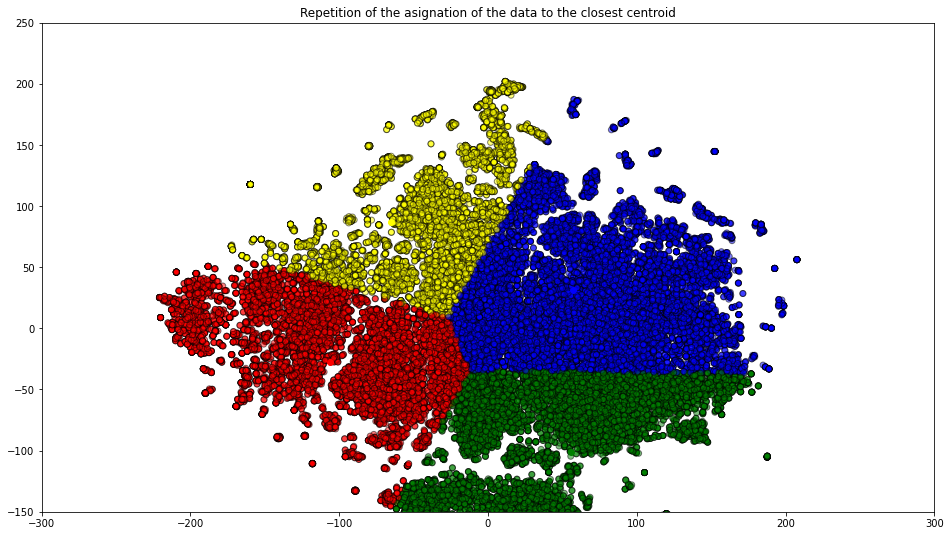

In [ ]:
## Repetition of the asignation of the data to the closest centroid
 
df = asignacion(df, centroids)
# Representing the results
fig = plt.figure(figsize=(16, 9))
plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.title(u'Repetition of the asignation of the data to the closest centroid')
plt.xlim(-300, 300)
plt.ylim(-150, 250)
plt.show()

In [ ]:
df

,x,y,distance_from_1,distance_from_2,distance_from_3,distance_from_4,closest,color
0,-84.119705,63.309471,93.169643,216.128602,145.011112,30.317710,4,yellow
1,105.355484,-6.485344,212.508084,107.178382,60.962090,194.498941,3,b
2,67.976555,-82.430168,182.658494,22.649725,113.876227,215.508117,2,g
3,-122.829002,-87.453690,62.502456,179.102708,215.496118,183.726366,1,r
4,-159.651276,117.618454,154.408744,307.230008,233.563402,99.287222,4,yellow
...,...,...,...,...,...,...,...,...
46575,152.211929,5.779670,260.449617,144.272355,98.255406,232.090620,3,b
46576,-193.844269,-15.193384,88.526590,264.063342,255.279094,164.293784,1,r
46577,-29.618925,94.854408,144.075116,214.080265,107.835016,36.439939,4,yellow
46578,120.200554,-56.161850,228.181860,78.809628,107.477559,234.243576,2,g


In [ ]:
#we add the tewwt to each point correspondingly
df['text']=dictionary

In [ ]:
df

,x,y,distance_from_1,distance_from_2,distance_from_3,distance_from_4,closest,color,text
0,-84.119705,63.309471,93.169643,216.128602,145.011112,30.317710,4,yellow,Oh yr eh ohi nhi aa jine corona kr k parliamen...
1,105.355484,-6.485344,212.508084,107.178382,60.962090,194.498941,3,b,@sambosnumerouno @MENnewsdesk @ccoxmenmedia Ye...
2,67.976555,-82.430168,182.658494,22.649725,113.876227,215.508117,2,g,How about not acknowledging Covid\nThe dangers...
3,-122.829002,-87.453690,62.502456,179.102708,215.496118,183.726366,1,r,fuck we really boutta be 5-9 😔 https://t.co/h8...
4,-159.651276,117.618454,154.408744,307.230008,233.563402,99.287222,4,yellow,oh no 😂 https://t.co/op7jImeDRi
...,...,...,...,...,...,...,...,...,...
46575,152.211929,5.779670,260.449617,144.272355,98.255406,232.090620,3,b,@Morning_Joe @kasie That’s pathetic honestly h...
46576,-193.844269,-15.193384,88.526590,264.063342,255.279094,164.293784,1,r,@EricLiptonNYT Guess again! \n\nhttps://t.co/a...
46577,-29.618925,94.854408,144.075116,214.080265,107.835016,36.439939,4,yellow,"Na stress ako. covid, spare seventeen please 😭"
46578,120.200554,-56.161850,228.181860,78.809628,107.477559,234.243576,2,g,"Good for Christie for admitting he was wrong, ..."


In [ ]:
dfcopy=df.copy()

In [ ]:
#we create 4 dataframes each with each cluster
df_1=dfcopy[dfcopy['closest']==1]
df_2=dfcopy[dfcopy['closest']==2]
df_3=dfcopy[dfcopy['closest']==3]
df_4=dfcopy[dfcopy['closest']==4]
#df_5=dfcopy[dfcopy['closest']==5]

In [ ]:
#we drop the unnecessary distances
df_1=df_1.drop(['distance_from_2','distance_from_3','distance_from_4'], axis=1)
df_2=df_2.drop(['distance_from_1','distance_from_3','distance_from_4'], axis=1)
df_3=df_3.drop(['distance_from_2','distance_from_1','distance_from_4'], axis=1)
df_4=df_4.drop(['distance_from_2','distance_from_3','distance_from_1'], axis=1)
#df_5=df_5.drop(['distance_from_2','distance_from_3','distance_from_4','distance_from_1'], axis=1)

In [ ]:
#and rename the one that remains with the same number
df_1=df_1.rename(columns = {'distance_from_1':'distance'})
df_2=df_2.rename(columns = {'distance_from_2':'distance'})
df_3=df_3.rename(columns = {'distance_from_3':'distance'})
df_4=df_4.rename(columns = {'distance_from_4':'distance'})
#df_5=df_5.rename(columns = {'distance_from_5':'distance'})

In [ ]:
#we sort each cluster by the distance value in increasing order to know which tweet is the closest to its centroid
df_1 = df_1.sort_values('distance')
df_2 = df_2.sort_values('distance')
df_3 = df_3.sort_values('distance')
df_4 = df_4.sort_values('distance')
#df_5 = df_5.sort_values('distance')

In [ ]:
dfs=[df_1,df_2,df_3,df_4]

In [ ]:
#we create a bag of words of each cluster 
bag_of_words_per_dataframe=[]
for dataframe in dfs:
  bag_of_words = {}
  for text in dataframe["text"]:
    
      lst_text = preprocess_tweet(text)    
      
      # create bag-of-words - for each word the frequency of the word in the corpus
      for w in lst_text:
        if w not in bag_of_words:
          bag_of_words[w] = 0
        bag_of_words[w] +=1
  bag_of_words_per_dataframe.append(bag_of_words)

In [ ]:
#we sort each baf of words of each cluster in order to find the top 5 most popular words
import operator
bag_of_words_per_dataframe_sorted=[]
for i in range (0,len(bag_of_words_per_dataframe)):

  bag_of_words_per_dataframe_sorted.append( sorted(bag_of_words_per_dataframe[i].items(), key=operator.itemgetter(1), reverse=True))


In [ ]:
#we create the dataframe for visualizing the results
top_5 = []
top=5
for i in range(0,len(bag_of_words_per_dataframe_sorted)):
  aux=[]
  for j in bag_of_words_per_dataframe_sorted[i][:top]:
    aux.append(j)
  top_5.append(aux)

In [ ]:
top_5_dataframe=pd.DataFrame()
top_5_dataframe['Cluster number 1 top 5 words']=top_5[0]
top_5_dataframe['Cluster number 2 top 5 words']=top_5[1]
top_5_dataframe['Cluster number 3 top 5 words']=top_5[2]
top_5_dataframe['Cluster number 4 top 5 words']=top_5[3]
#top_5_dataframe['Cluster number 5 top 5 words']=top_5[4]

In [ ]:
top_5_dataframe

,Cluster number 1 top 5 words,Cluster number 2 top 5 words,Cluster number 3 top 5 words,Cluster number 4 top 5 words
0,"(vaccin, 3758)","(mask, 4414)","(covid, 4339)","(covid, 3114)"
1,"(covid19, 1286)","(pandem, 2804)","(covid19, 3969)","(covid19, 1561)"
2,"(get, 1111)","(peopl, 2551)","(vaccin, 3345)","(test, 1221)"
3,"(covid, 650)","(covid, 2193)","(death, 2757)","(posit, 809)"
4,"(peopl, 591)","(wear, 1983)","(pandem, 2502)","(lockdown, 707)"


In [ ]:
top_5_dataframe.to_csv(output_path+"top_5_dataframe.csv", sep =";")